## Imports

In [1]:
# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset
from torchvision import transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Torch device:", device) # Quick check to see if we're using GPU or CPU.


from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from pathlib import Path

# Personal imports
import dataset.download_and_preprocess as dl
from dataset.dataloader import KTHDataset
from autoencoder.autoencoder import AutoencoderModel


import matplotlib.pyplot as plt


Torch device: cuda


## Download the dataset and pre-process the dataset

In [2]:
action_space = ['walking', 'running', 'jogging', 'boxing', 'handwaving', 'handclapping']
for action in action_space:
    should_extract = dl.download_and_extract(action, overwrite=False)
    dl.extract_and_save_frames(action, extraction=should_extract)

## Split the data into train, test, validate

In [ ]:
from random import randint
image_file_names = []
labels = []

# Create a list of all the image file names and their corresponding action labels
for action in action_space:
    folder = Path("dataset") / "KTH_data" / action
    for f in folder.glob("*.pt"):
        i += 1
        image_file_names.append(f)
        labels.append(action)
        
paths = np.array(image_file_names)
labels = np.array(labels)

In [4]:
# Split the dataset into training, validation, and test sets
# 70% training, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    paths, labels, 
    stratify=labels, 
    test_size=0.3, 
    random_state=42
)
# Split the temporary set into validation and test sets
# 50% of the temporary set for validation and 50% for testing (again, 15% each overall)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    stratify=y_temp, 
    test_size=0.5, 
    random_state=42
)


# Data augmentation for training
train_transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.from_numpy(x) if isinstance(x, np.ndarray) else x),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5)
])

val_test_transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.from_numpy(x) if isinstance(x, np.ndarray) else x)
])


train_dataset = KTHDataset(X_train, y_train, transform=train_transform)
val_dataset = KTHDataset(X_val, y_val, transform=val_test_transform)
test_dataset = KTHDataset(X_test, y_test, transform=val_test_transform)

# Create sample weights based on training label frequency

# Map class names to integer indices
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(action_space)}
y_train_indices = np.array([class_to_idx[label] for label in y_train])

class_sample_count = np.bincount(y_train_indices)
class_weights = 1. / class_sample_count
sample_weights = class_weights[y_train_indices]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

In [5]:
# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Epoch [1/100] Train Loss: 0.0087 Val Loss: 0.0079
Epoch [2/100] Train Loss: 0.0074 Val Loss: 0.0071
Epoch [3/100] Train Loss: 0.0056 Val Loss: 0.0047
Epoch [4/100] Train Loss: 0.0043 Val Loss: 0.0039
Epoch [5/100] Train Loss: 0.0032 Val Loss: 0.0033
Epoch [6/100] Train Loss: 0.0029 Val Loss: 0.0028
Epoch [7/100] Train Loss: 0.0026 Val Loss: 0.0025
Epoch [8/100] Train Loss: 0.0023 Val Loss: 0.0023
Epoch [9/100] Train Loss: 0.0024 Val Loss: 0.0023
Epoch [10/100] Train Loss: 0.0022 Val Loss: 0.0023
Epoch [11/100] Train Loss: 0.0022 Val Loss: 0.0022
Epoch [12/100] Train Loss: 0.0021 Val Loss: 0.0021
Epoch [13/100] Train Loss: 0.0020 Val Loss: 0.0021
Epoch [14/100] Train Loss: 0.0019 Val Loss: 0.0021
Epoch [15/100] Train Loss: 0.0019 Val Loss: 0.0020
Epoch [16/100] Train Loss: 0.0018 Val Loss: 0.0020
Epoch [17/100] Train Loss: 0.0018 Val Loss: 0.0020
Epoch [18/100] Train Loss: 0.0018 Val Loss: 0.0019
Epoch [19/100] Train Loss: 0.0017 Val Loss: 0.0019
Epoch [20/100] Train Loss: 0.0017 Val Lo

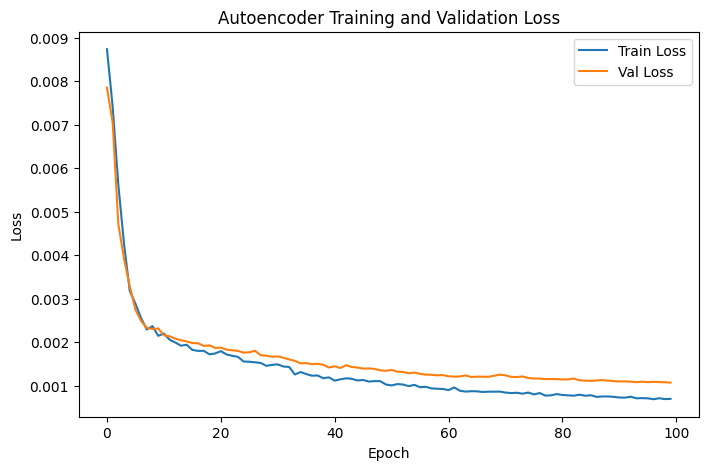

In [7]:
num_epochs = 100
model = AutoencoderModel(latent_dim=100).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print("Epoch", epoch+1, end='\r')
    model.train()
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.unsqueeze(1).to(device)
        outputs = model(images)
        loss = criterion(outputs, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, _ in val_loader:
            images = images.unsqueeze(1).to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f} Val Loss: {val_loss:.4f}")

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(train_losses, label='Train Loss', color='tab:blue')
ax.plot(val_losses, label='Val Loss', color='tab:orange')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Autoencoder Training and Validation Loss')
ax.legend()
plt.show()


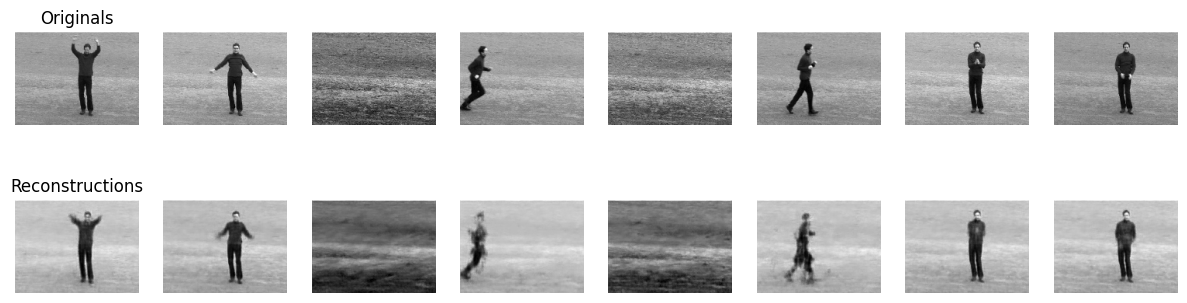

In [10]:
model.eval()
with torch.no_grad():
    sample_imgs, _ = next(iter(test_loader))
    sample_imgs = sample_imgs.unsqueeze(1).to(device)
    reconstructions = model(sample_imgs)

fig, axs = plt.subplots(2, 8, figsize=(15, 4))
for i in range(8):
    axs[0, i].imshow(sample_imgs[i, 0].cpu(), cmap='gray')
    axs[1, i].imshow(reconstructions[i, 0].cpu(), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].axis('off')
axs[0, 0].set_title("Originals")
axs[1, 0].set_title("Reconstructions")
plt.show()


## TODO
1. Better visuals for the training loop.
2. AutoEncoder hyperparameter tuning.
3. Finding optimal latens space.
